## Using Keras for Word Embedding as well as the LSTM

https://towardsdatascience.com/recurrent-neural-networks-by-example-in-python-ffd204f99470

https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

https://keras.io/getting-started/functional-api-guide/

In [1]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import json
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import time
sys.path.append("..")

from app.services.data_preparation import get_processed_data_sets_for_model, DATA_FILES_DIR
from app.services.model_helper import TIME_OFFSET, ModelHelper
from app.services import keras_lstm_features

from app.services.sentence_tokenizer import get_chat_log_sequences_and_chat_logs, MAX_CHAT_LENGTH, TOP_WORDS
from keras.callbacks import ModelCheckpoint
from keras.layers import Bidirectional, Dense, Dropout, Input, LSTM, TimeDistributed, LeakyReLU
from keras.layers.embeddings import Embedding
from keras.models import Sequential, Model, load_model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from os.path import join

Using TensorFlow backend.


In [2]:
processed_data, data_type_log_ids, train_validation_and_test_dates = get_processed_data_sets_for_model(
    include_word_sequences=True,
    sequence_size=73
)

In [3]:
print(type(processed_data["validation_features_X"].tail().values))

<class 'numpy.ndarray'>


In [4]:
processed_data.keys()

dict_keys(['test_y', 'validation_features_X', 'train_y', 'test_features_X', 'train_features_X', 'validation_y', 'train_sequences_X', 'train_chat_logs', 'validation_sequences_X', 'validation_chat_logs', 'test_sequences_X', 'test_chat_logs'])

In [5]:
(
    train_sentence_vectors, 
    validation_sentence_vectors, 
    test_sentence_vectors
) = keras_lstm_features.load_sentence_vectors()

In [6]:
# train_sentence_vectors[0]

In [7]:
train_features_X = processed_data["train_features_X"]
validation_features_X = processed_data["validation_features_X"]
test_features_X = processed_data["test_features_X"]
print(train_features_X.tail())

assert train_features_X.shape[1] == test_features_X.shape[1] 
assert test_features_X.shape[1] == validation_features_X.shape[1] 
print(test_features_X.shape)
test_features_X[:5]

       absolute_sentence_position  sentence_length  number_of_special_terms  \
13728                    0.992537         0.082192                 0.027027   
13729                    0.994403         0.000000                 0.000000   
13730                    0.996269         0.438356                 0.027027   
13731                    0.998134         0.027397                 0.027027   
13732                    1.000000         0.041096                 0.000000   

       sentiment_score  normalized_mean_tf_idf  normalized_mean_tf_isf  
13728         0.680659                0.007117                0.100894  
13729         0.481478                0.000000                0.000000  
13730         0.714451                0.006696                0.017713  
13731         0.481478                0.004437                0.322041  
13732         0.000000                0.004600                0.209270  
(3405, 6)


,absolute_sentence_position,sentence_length,number_of_special_terms,sentiment_score,normalized_mean_tf_idf,normalized_mean_tf_isf
0,0.001182,0.028169,0.142857,0.000000,0.005692,0.368636
1,0.002364,0.084507,0.285714,0.000000,0.007438,0.114519
2,0.003546,0.028169,0.000000,0.000000,0.006591,0.260825
3,0.004728,0.098592,0.000000,0.000000,0.011325,0.086599
4,0.005910,0.014085,0.000000,0.160904,0.006633,0.665037


In [8]:
train_sequences_X, train_chat_logs = (processed_data["train_sequences_X"], processed_data["train_chat_logs"])
validation_sequences_X, validation_chat_logs = (processed_data["validation_sequences_X"], 
                                                processed_data["validation_chat_logs"])
test_sequences_X, test_chat_logs = (processed_data["test_sequences_X"], processed_data["test_chat_logs"])
print(train_sequences_X.shape)
print(test_sequences_X.shape)
print(train_sequences_X[:1])
print(len(test_sequences_X))
test_chat_logs[:2]


(13733, 73)
(3405, 73)
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    4 1359   18  108   15    3 4900  918   12
   115  786   14]]
3405


['hey reinhard\n', 'did jonas ever hack on GNUe?\n']

In [9]:
train_y = processed_data["train_y"]
validation_y = processed_data["validation_y"]
test_y = processed_data["test_y"]
print(test_y.shape)
test_y

(3405, 2)


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [10]:
data_type_log_ids["test"][:5]

[144080, 144081, 144082, 144083, 144084]

In [11]:
train_y

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [12]:
train_y_labels = [0 if list(label) == [1, 0] else 1 for label in train_y]
train_y_labels[60: 80]
np.unique(train_y_labels)
# j = [1,0]
# j == [1,0]
# list(train_y[0])

array([0, 1])

In [13]:
model_helper = ModelHelper()

In [10]:
# Sentence input: meant to receive sequences of `max_chat_length` integers, between 1 and `top_words`.
main_sentence_input = Input(shape=(MAX_CHAT_LENGTH,), dtype='int32', name='main_sentence_input')

# This embedding layer will encode the input sequence
# into a sequence of dense 512-dimensional vectors.
x = Embedding(output_dim=512, input_dim=TOP_WORDS, input_length=MAX_CHAT_LENGTH)(main_sentence_input)

# An LSTM will transform the vector sequence into a single vector,
# containing information about the entire sequence
lstm_out = LSTM(32)(x)

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
class_weights = class_weight.compute_class_weight(
    'balanced',
    np.unique(train_y_labels),
    train_y_labels
)
class_weights

array([ 0.51756237, 14.73497854])

In [19]:
EPOCHS = 500
BATCH_SIZE = 64
OPTIMIZER = "adam"
OUTPUT_ACTIVATION = "sigmoid"
# Here we insert the auxiliary loss, allowing the LSTM and Embedding layer 
# to be trained smoothly even though the main loss will be much higher in the model.
auxiliary_output = Dense(2, activation=OUTPUT_ACTIVATION, name='aux_output')(lstm_out)

# At this point, we feed into the model our auxiliary input data by 
# concatenating it with the LSTM output
num_of_feature_columns = test_features_X.shape[1]
sentence_features_input = Input(shape=(num_of_feature_columns,), name='sentence_features_input')
merged_input_and_output = keras.layers.concatenate([lstm_out, sentence_features_input])

# We stack a deep densely-connected network on top
x = Dense(64, activation='relu')(merged_input_and_output)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)

# And finally we add the main logistic regression layer
main_output = Dense(2, activation=OUTPUT_ACTIVATION, name='main_output')(x)

In [20]:
# Define a model with two inputs and two outputs
merged_model = Model(
    inputs=[main_sentence_input, sentence_features_input], 
    outputs=[main_output, auxiliary_output]
)

In [11]:
checkpointer, checkpoints_dir = (
    model_helper.fetch_checkpointer(EPOCHS, BATCH_SIZE, OPTIMIZER),
    model_helper.checkpoints_dir
)

NameError: name 'EPOCHS' is not defined

In [ ]:
checkpoints_dir

We compile the model and assign a weight of 0.2 to the auxiliary loss. To specify different loss_weights or loss for each different output, you can use a list or a dictionary. Here we pass a single loss as the loss argument, so the same loss will be used on all outputs.

In [31]:
merged_model.compile(
    optimizer=OPTIMIZER, 
    #optimizer="adam",
    loss='categorical_crossentropy',
    loss_weights=[.9, 0.7],
    #sample_weight_mode="temporal"
)
merged_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_sentence_input (InputLayer (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 512)     5120000     main_sentence_input[0][0]        
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 32)           69760       embedding_1[0][0]                
__________________________________________________________________________________________________
sentence_features_input (InputL (None, 6)            0                                            
__________________________________________________________________________________________________
concatenat

In [32]:
# Train the model by passing it lists of input arrays and target arrays 19960.996418952942  seconds
# 25183.798012971878  seconds Second time, with 30 minute break in between
start = time.time()
merged_model_history = merged_model.fit(
    [train_sequences_X, train_features_X], 
    [train_y, train_y],
    #validation_split=0.2,
    validation_data=[
        [validation_sequences_X, validation_features_X], 
        [validation_y, validation_y]
    ],
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE,
    callbacks=[checkpointer]
    #class_weight=[class_weights, class_weights]
)
end = time.time()
time_taken_in_minutes = (end-start)//60
print(end - start, " seconds")

Train on 13733 samples, validate on 3577 samples
Epoch 1/500
13733/13733 [==============================] - 46s 3ms/step - loss: 0.0251 - main_output_loss: 0.0153 - aux_output_loss: 0.0162 - val_loss: 0.5367 - val_main_output_loss: 0.3882 - val_aux_output_loss: 0.2676
Epoch 2/500
13733/13733 [==============================] - 45s 3ms/step - loss: 0.0157 - main_output_loss: 0.0090 - aux_output_loss: 0.0109 - val_loss: 0.5271 - val_main_output_loss: 0.3773 - val_aux_output_loss: 0.2678
Epoch 3/500
13733/13733 [==============================] - 41s 3ms/step - loss: 0.0130 - main_output_loss: 0.0080 - aux_output_loss: 0.0083 - val_loss: 0.7509 - val_main_output_loss: 0.5900 - val_aux_output_loss: 0.3142
Epoch 4/500
13733/13733 [==============================] - 41s 3ms/step - loss: 0.0096 - main_output_loss: 0.0055 - aux_output_loss: 0.0066 - val_loss: 0.6541 - val_main_output_loss: 0.5112 - val_aux_output_loss: 0.2772

Epoch 00004: saving model to ../feature_extraction/data_files/1157354_

Epoch 36/500
13733/13733 [==============================] - 40s 3ms/step - loss: 0.0054 - main_output_loss: 0.0034 - aux_output_loss: 0.0034 - val_loss: 0.7966 - val_main_output_loss: 0.5653 - val_aux_output_loss: 0.4113
Epoch 37/500
13733/13733 [==============================] - 41s 3ms/step - loss: 0.0054 - main_output_loss: 0.0033 - aux_output_loss: 0.0034 - val_loss: 0.8180 - val_main_output_loss: 0.5846 - val_aux_output_loss: 0.4169
Epoch 38/500
13733/13733 [==============================] - 41s 3ms/step - loss: 0.0053 - main_output_loss: 0.0033 - aux_output_loss: 0.0033 - val_loss: 0.8197 - val_main_output_loss: 0.5833 - val_aux_output_loss: 0.4210
Epoch 39/500
13733/13733 [==============================] - 41s 3ms/step - loss: 0.0052 - main_output_loss: 0.0032 - aux_output_loss: 0.0033 - val_loss: 0.8201 - val_main_output_loss: 0.5829 - val_aux_output_loss: 0.4222
Epoch 40/500
13733/13733 [==============================] - 42s 3ms/step - loss: 0.0054 - main_output_loss: 0.0033 -

Epoch 106/500
13733/13733 [==============================] - 41s 3ms/step - loss: 0.0047 - main_output_loss: 0.0028 - aux_output_loss: 0.0031 - val_loss: 0.9755 - val_main_output_loss: 0.6733 - val_aux_output_loss: 0.5278
Epoch 107/500
13733/13733 [==============================] - 40s 3ms/step - loss: 0.0048 - main_output_loss: 0.0029 - aux_output_loss: 0.0031 - val_loss: 0.9810 - val_main_output_loss: 0.6802 - val_aux_output_loss: 0.5269
Epoch 108/500
13733/13733 [==============================] - 40s 3ms/step - loss: 0.0048 - main_output_loss: 0.0029 - aux_output_loss: 0.0032 - val_loss: 0.9974 - val_main_output_loss: 0.6954 - val_aux_output_loss: 0.5308
Epoch 109/500
13733/13733 [==============================] - 41s 3ms/step - loss: 0.0049 - main_output_loss: 0.0030 - aux_output_loss: 0.0032 - val_loss: 1.0264 - val_main_output_loss: 0.7147 - val_aux_output_loss: 0.5474
Epoch 110/500
13733/13733 [==============================] - 41s 3ms/step - loss: 0.0048 - main_output_loss: 0.0

Epoch 176/500
13733/13733 [==============================] - 41s 3ms/step - loss: 0.0047 - main_output_loss: 0.0028 - aux_output_loss: 0.0031 - val_loss: 1.1750 - val_main_output_loss: 0.8651 - val_aux_output_loss: 0.5663
Epoch 177/500
13733/13733 [==============================] - 41s 3ms/step - loss: 0.0049 - main_output_loss: 0.0030 - aux_output_loss: 0.0032 - val_loss: 1.1381 - val_main_output_loss: 0.8369 - val_aux_output_loss: 0.5498
Epoch 178/500
13733/13733 [==============================] - 42s 3ms/step - loss: 0.0046 - main_output_loss: 0.0027 - aux_output_loss: 0.0032 - val_loss: 1.1419 - val_main_output_loss: 0.8374 - val_aux_output_loss: 0.5546
Epoch 179/500
13733/13733 [==============================] - 42s 3ms/step - loss: 0.0046 - main_output_loss: 0.0027 - aux_output_loss: 0.0032 - val_loss: 1.1564 - val_main_output_loss: 0.8501 - val_aux_output_loss: 0.5590
Epoch 180/500
13733/13733 [==============================] - 40s 3ms/step - loss: 0.0046 - main_output_loss: 0.0

Epoch 246/500
13733/13733 [==============================] - 42s 3ms/step - loss: 0.0045 - main_output_loss: 0.0026 - aux_output_loss: 0.0031 - val_loss: 1.0684 - val_main_output_loss: 0.7852 - val_aux_output_loss: 0.5168
Epoch 247/500
13733/13733 [==============================] - 41s 3ms/step - loss: 0.0046 - main_output_loss: 0.0026 - aux_output_loss: 0.0031 - val_loss: 1.0909 - val_main_output_loss: 0.8062 - val_aux_output_loss: 0.5219
Epoch 248/500
13733/13733 [==============================] - 41s 3ms/step - loss: 0.0046 - main_output_loss: 0.0027 - aux_output_loss: 0.0031 - val_loss: 1.1015 - val_main_output_loss: 0.8139 - val_aux_output_loss: 0.5272
Epoch 249/500
13733/13733 [==============================] - 40s 3ms/step - loss: 0.0046 - main_output_loss: 0.0026 - aux_output_loss: 0.0031 - val_loss: 1.1053 - val_main_output_loss: 0.8168 - val_aux_output_loss: 0.5288
Epoch 250/500
13733/13733 [==============================] - 41s 3ms/step - loss: 0.0046 - main_output_loss: 0.0

Epoch 316/500
13733/13733 [==============================] - 41s 3ms/step - loss: 0.0045 - main_output_loss: 0.0025 - aux_output_loss: 0.0031 - val_loss: 1.2439 - val_main_output_loss: 0.9186 - val_aux_output_loss: 0.5960
Epoch 317/500
13733/13733 [==============================] - 41s 3ms/step - loss: 0.0044 - main_output_loss: 0.0025 - aux_output_loss: 0.0031 - val_loss: 1.2449 - val_main_output_loss: 0.9183 - val_aux_output_loss: 0.5978
Epoch 318/500
13733/13733 [==============================] - 41s 3ms/step - loss: 0.0047 - main_output_loss: 0.0028 - aux_output_loss: 0.0031 - val_loss: 1.2352 - val_main_output_loss: 0.9068 - val_aux_output_loss: 0.5987
Epoch 319/500
13733/13733 [==============================] - 41s 3ms/step - loss: 0.0046 - main_output_loss: 0.0027 - aux_output_loss: 0.0031 - val_loss: 1.2410 - val_main_output_loss: 0.9112 - val_aux_output_loss: 0.6013
Epoch 320/500
13733/13733 [==============================] - 41s 3ms/step - loss: 0.0046 - main_output_loss: 0.0

Epoch 386/500
13733/13733 [==============================] - 42s 3ms/step - loss: 0.0045 - main_output_loss: 0.0025 - aux_output_loss: 0.0031 - val_loss: 0.9836 - val_main_output_loss: 0.6754 - val_aux_output_loss: 0.5367
Epoch 387/500
13733/13733 [==============================] - 42s 3ms/step - loss: 0.0044 - main_output_loss: 0.0025 - aux_output_loss: 0.0031 - val_loss: 0.9864 - val_main_output_loss: 0.6766 - val_aux_output_loss: 0.5392
Epoch 388/500
13733/13733 [==============================] - 40s 3ms/step - loss: 0.0045 - main_output_loss: 0.0026 - aux_output_loss: 0.0031 - val_loss: 1.0006 - val_main_output_loss: 0.6904 - val_aux_output_loss: 0.5418
Epoch 389/500
13733/13733 [==============================] - 41s 3ms/step - loss: 0.0045 - main_output_loss: 0.0026 - aux_output_loss: 0.0031 - val_loss: 0.9837 - val_main_output_loss: 0.6696 - val_aux_output_loss: 0.5444
Epoch 390/500
13733/13733 [==============================] - 42s 3ms/step - loss: 0.0044 - main_output_loss: 0.0

Epoch 456/500
13733/13733 [==============================] - 41s 3ms/step - loss: 0.0045 - main_output_loss: 0.0025 - aux_output_loss: 0.0031 - val_loss: 1.1684 - val_main_output_loss: 0.7753 - val_aux_output_loss: 0.6724
Epoch 457/500
13733/13733 [==============================] - 42s 3ms/step - loss: 0.0045 - main_output_loss: 0.0026 - aux_output_loss: 0.0031 - val_loss: 1.1775 - val_main_output_loss: 0.7848 - val_aux_output_loss: 0.6731
Epoch 458/500
13733/13733 [==============================] - 42s 3ms/step - loss: 0.0045 - main_output_loss: 0.0026 - aux_output_loss: 0.0031 - val_loss: 1.1877 - val_main_output_loss: 0.7958 - val_aux_output_loss: 0.6735
Epoch 459/500
13733/13733 [==============================] - 42s 3ms/step - loss: 0.0044 - main_output_loss: 0.0025 - aux_output_loss: 0.0031 - val_loss: 1.1872 - val_main_output_loss: 0.7942 - val_aux_output_loss: 0.6749
Epoch 460/500
13733/13733 [==============================] - 42s 3ms/step - loss: 0.0044 - main_output_loss: 0.0

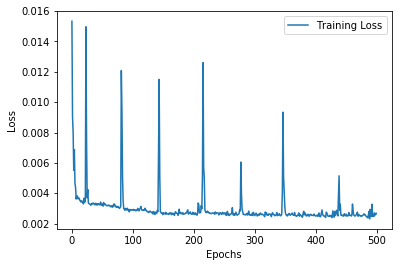

In [80]:
merged_model_loss_values = merged_model_history.history['main_output_loss']
validation_loss = merged_model_history.history['val_main_output_loss']
merged_model_epochs = merged_model_history.epoch
plt.plot(merged_model_epochs, merged_model_loss_values, label='Training Loss')
# plt.plot(merged_model_epochs, validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [36]:
# Reset validation data and model since they are not serializable
merged_model_history.validation_data = []
merged_model_history.model = str(merged_model_history.model.__dict__)

AttributeError: 'str' object has no attribute '__dict__'

In [73]:
merged_model_history.params["steps"] = ""

In [59]:
for k, v in merged_model_history.__dict__.items():
    if v is None:
        print(k, v)

In [63]:
# Save model params and history
model_helper.save_model_details(merged_model_history.__dict__)

In [42]:
print(checkpoints_dir)

../feature_extraction/data_files/1157354_checkpoints_hybrid_500e_64b_adam


In [43]:
# current_time = time.strftime("%Y-%m-%d-(%H_%M_%S)")
merged_model_filename = "{}df_{}e_{}bs_{}_{}min".format(
    model_helper.time_diff, 
    EPOCHS, 
    BATCH_SIZE, 
    OPTIMIZER,
    int(time_taken_in_minutes)
)
MODELS_DIR = join(DATA_FILES_DIR, "models")
merged_model_filename = join(MODELS_DIR,  merged_model_filename + '_merged_hybrid_model.h5')
merged_model_filename

'../feature_extraction/data_files/models/1157354df_500e_64bs_adam_342min_merged_hybrid_model.h5'

In [44]:
merged_model.save(merged_model_filename)

In [14]:
merged_model_filename = join("..", "app", "services", "chat_data_files", 
                             "models", "model-40-30ts_bidi.hdf5")
merged_model_filename

'../app/services/chat_data_files/models/model-40-30ts_bidi.hdf5'

In [40]:
keras_lstm_features.test_sequences.shape

AttributeError: module 'app.services.keras_lstm_features' has no attribute 'test_sequences'

In [196]:
models_folders = {
    "30_ts_0.5_dro_lstm": {
        "inputs": [keras_lstm_features.create_time_steps(test_sequences_X, 30)],
        "models": []
    },
    "30_ts_bidi_lstm_hybrid": {
        "inputs": [keras_lstm_features.create_time_steps(test_sequences_X, 30)],
        "models": []
    },
    "30_ts_lstm_hybrid": {
        "inputs": [keras_lstm_features.create_time_steps(test_sequences_X, 30), test_features_X],
        "models": []
    },
    "30_ts_lstm_sequences_features": {
        "inputs": [keras_lstm_features.test_sequences_features_concat],
        "models": []
    },
    "30ts_0.5dro_lstm2": {
        "inputs": [keras_lstm_features.test_sequences],
        "models": []
    },
    "50_ts_bidi_lstm_features": {
        "inputs": [keras_lstm_features.test_features_X],
        "models": []
    },
    "50_ts_lstm_features": {
        "inputs": [keras_lstm_features.test_features_X],
        "models": []
    },
    "100_ts_05_dro_32_hino_lstm2": {
        "inputs": [keras_lstm_features.test_sequences],
        "models": []
    },
    "100_ts_05_dro_lstm2": {
        "inputs": [keras_lstm_features.test_sequences],
        "models": []
    }
}


In [188]:
base_models_dir = join("..", "app", "services", "chat_data_files", "models")
def load_model_files(models_folders): 
    for model_folder in models_folders.keys():
        model_dir = join(base_models_dir, model_folder)
        print("\nCurrent directory: ", model_dir)
        for model_filename in sorted(os.listdir(model_dir)):
            if model_filename.endswith(".hdf5"):
                print("\tModel: ", model_filename)
                models_folders[model_folder]["models"].append(load_model(join(model_dir, model_filename)))

In [ ]:
# load_model_files(models_folders)

In [15]:
# models_folders

In [52]:
# models_folders

In [66]:
# merged_model_filename = join(DATA_FILES_DIR, "models", "merged_hybrid_model.h5")

In [15]:
loaded_merged_model = load_model(merged_model_filename)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [136]:
cp_dir = join("..", "app", "services", "chat_data_files", "models", "100_ts_05_dro_32_hino_lstm2")
model_details = model_helper.load_model_details(
    checkpoints_dir=cp_dir, 
    model_details_filename="model_details.json"
)
model_details["history"].keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

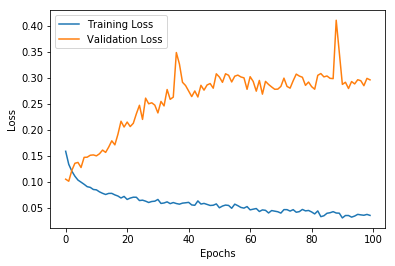

In [137]:
# merged_model_loss_values = model_details['history']['main_output_loss']
# validation_loss = model_details['history']['val_main_output_loss']
merged_model_loss_values = model_details['history']['loss']
validation_loss = model_details['history']['val_loss']
merged_model_epochs = model_details['epoch']
plt.plot(merged_model_epochs, merged_model_loss_values, label='Training Loss')
plt.plot(merged_model_epochs, validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [16]:
TIME_STEPS = 30

In [17]:
test_vectors = np.array(keras_lstm_features.get_sentence_vectors("test"))

In [18]:
test_vectors = keras_lstm_features.create_time_steps(np.array(test_vectors), TIME_STEPS)
test_vectors[:1]

array([[[-0.31162995,  1.7198551 , -0.26658484, ...,  0.26755935,
         -0.25971437,  0.25458497],
        [ 0.7395397 , -0.04442636,  0.01110798, ..., -0.33860877,
          0.2671296 ,  1.0992235 ],
        [ 0.06799658,  0.12074675, -1.2979059 , ...,  0.4600182 ,
         -1.2451937 ,  0.1859076 ],
        ...,
        [-0.6919389 ,  2.9159625 , -1.628642  , ..., -0.8936053 ,
          1.2516016 , -0.8342527 ],
        [ 0.95484793, -0.20202481, -0.02437298, ..., -0.3512085 ,
         -0.79204888, -0.02689505],
        [ 0.25896859, -0.6449706 , -0.23375711, ...,  0.15994361,
          0.01313286,  0.11158396]]])

In [19]:
validation_vectors = np.array(keras_lstm_features.get_sentence_vectors("validation"))

In [20]:
validation_vectors = keras_lstm_features.create_time_steps(np.array(validation_vectors), TIME_STEPS)
validation_vectors[:1]

array([[[ 0.43083695, -0.49769064,  0.1643314 , ..., -0.4650444 ,
         -0.58196433,  0.02166187],
        [ 1.15913795,  0.22453519,  0.33209156, ...,  0.01474681,
         -0.91038723,  0.26871113],
        [ 0.960371  , -0.21186292,  0.07468702, ..., -1.5586987 ,
         -0.596789  , -0.91772795],
        ...,
        [ 0.53636575, -0.11782386,  0.00602838, ...,  0.22712874,
          0.33111453, -0.38606647],
        [-0.02151288,  1.2117786 , -0.42026448, ..., -0.66378164,
         -0.99202967,  0.5660049 ],
        [-0.23964867,  0.1461363 , -0.3329837 , ..., -0.34872812,
         -0.11727129, -1.2159463 ]]])

In [20]:
def get_y_predictions_from_models(model_dict):
    
    for model_dir, model_data in model_dict.items():
        model_dir = join(base_models_dir, model_dir)
        model_names = sorted(os.listdir(model_dir))
        model_data["model_names"] = model_names
        print(model_dir)
        model_data["y_predictions"] = []
        for model in model_data["models"]:
            model_data["y_predictions"].append(model.predict(model_data["inputs"]))
        

In [197]:
get_y_predictions_from_models(models_folders)

../app/services/chat_data_files/models/30_ts_0.5_dro_lstm
../app/services/chat_data_files/models/30_ts_bidi_lstm_hybrid
../app/services/chat_data_files/models/30_ts_lstm_hybrid
../app/services/chat_data_files/models/30_ts_lstm_sequences_features
../app/services/chat_data_files/models/30ts_0.5dro_lstm2
../app/services/chat_data_files/models/50_ts_bidi_lstm_features
../app/services/chat_data_files/models/50_ts_lstm_features
../app/services/chat_data_files/models/100_ts_05_dro_32_hino_lstm2
../app/services/chat_data_files/models/100_ts_05_dro_lstm2


In [17]:
# models_folders

In [21]:
# test_y_predictions = loaded_merged_model.predict([test_vectors, test_features_X])
# validation_y_predictions = loaded_merged_model.predict([validation_sequences_X, validation_features_X])

test_y_predictions = loaded_merged_model.predict([test_vectors])
# validation_y_predictions = loaded_merged_model.predict([validation_vectors])

# test_y_predictions = loaded_merged_model.predict([keras_lstm_features.test_sequences])
# validation_y_predictions = loaded_merged_model.predict([keras_lstm_features.validation_sequences])


test_y_argmax = np.argmax(test_y, axis=1)
# validation_y_argmax = np.argmax(validation_y,axis=1)

In [22]:
np.array(test_y_predictions).shape

(3405, 2)

In [23]:
# threshold = .45
# print(test_y_predictions)
# print(test_y_predictions[:,1])
# test_y_predictions_argmax = (test_y_predictions[1][:,1] > threshold).astype(int)      
# validation_y_predictions_argmax = (validation_y_predictions[:,1] > threshold).astype(int)

test_y_predictions_argmax = np.argmax(test_y_predictions, axis=1)
# validation_y_predictions_argmax = np.argmax(validation_y_predictions, axis=1)

# print(validation_y_predictions_argmax.shape)
# print(type(validation_y_predictions_argmax))
test_y_predictions_argmax

array([0, 0, 0, ..., 0, 0, 0])

In [24]:
test_y_predictions[:10]

array([[1.0000000e+00, 3.5293286e-09],
       [1.0000000e+00, 3.7725401e-09],
       [1.0000000e+00, 3.8646704e-09],
       [1.0000000e+00, 5.0865192e-09],
       [1.0000000e+00, 3.3800771e-09],
       [1.0000000e+00, 7.2508755e-09],
       [1.0000000e+00, 3.5973597e-09],
       [1.0000000e+00, 4.0525432e-09],
       [1.0000000e+00, 4.3629544e-09],
       [1.0000000e+00, 4.3824291e-09]], dtype=float32)

In [25]:
test_y_predictions_argmax[:200]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [26]:
test_y_argmax[:200]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [27]:
print(classification_report(test_y_argmax, test_y_predictions_argmax))
print(confusion_matrix(test_y_argmax, test_y_predictions_argmax))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      3282
           1       0.11      0.13      0.12       123

   micro avg       0.93      0.93      0.93      3405
   macro avg       0.54      0.55      0.54      3405
weighted avg       0.94      0.93      0.93      3405

[[3153  129]
 [ 107   16]]


In [28]:
classification_report(test_y_argmax, test_y_predictions_argmax, output_dict=True)

{'0': {'precision': 0.9671779141104294,
  'recall': 0.9606946983546618,
  'f1-score': 0.9639254050749007,
  'support': 3282},
 '1': {'precision': 0.1103448275862069,
  'recall': 0.13008130081300814,
  'f1-score': 0.11940298507462688,
  'support': 123},
 'micro avg': {'precision': 0.9306901615271659,
  'recall': 0.9306901615271659,
  'f1-score': 0.9306901615271659,
  'support': 3405},
 'macro avg': {'precision': 0.5387613708483181,
  'recall': 0.545387999583835,
  'f1-score': 0.5416641950747638,
  'support': 3405},
 'weighted avg': {'precision': 0.9362262343329024,
  'recall': 0.9306901615271659,
  'f1-score': 0.9334184277885471,
  'support': 3405}}

In [29]:
from rouge_metrics import *
from get_sentences_from_line_numbers import *

predicted_chat_logs = [test_chat_logs[index] for index, value in enumerate(test_y_predictions_argmax) if value==1]
summaries_chat_logs = [test_chat_logs[index] for index, value in enumerate(test_y_argmax) if value==1]

predicted_chat_logs = "".join(log for log in predicted_chat_logs)
summaries_chat_logs = "".join(log for log in summaries_chat_logs)
print("SUMMARIES\n---------\n", summaries_chat_logs[:1000])
print("PREDICTIONS\n-----------\n", predicted_chat_logs[:1000])

hypotheses = [predicted_chat_logs]
references = [summaries_chat_logs]
print("ROUGE Scores\n------------")
rouge_results, rouge_scores = get_rouge_results(hypotheses, references)
print_rouge_results(rouge_results)

SUMMARIES
---------
 where you planning a single exception raised to the app level or should I make forms handle the various errors at the app level
it's because the event system can't keep up with the movement
I'm going to make the provider='odbc' and take all the special meaning out of it
what's next big ticket in designer?
need to clean up the UI system
... add drag and drop support for automatically pulling fields/datasources
... generalize the designer code so that it can be used w/reports/etc
... use BOA (if installed) for code editing
insert a duplicate key into table
gnuef used to generate pop up dialogs and recover when a dberror was encountered
say I query 10 records
I have a resultset with 10 recordsets
I change the first 3 
which causes the _updateFlag's to be set on those records
and I insert a new record at the end
I go to commit the changes
and it performs the updates on the first 3
and resets the _updateFlag (since they've been updated)
then inserts the last one
but it 

In [32]:
rouge_scores

{'rouge-2': {'f': 0.08737864077669905,
  'p': 0.08823529411764706,
  'r': 0.08653846153846154},
 'rouge-4': {'f': 0.0396039603960396, 'p': 0.04, 'r': 0.0392156862745098},
 'rouge-3': {'f': 0.049019607843137254,
  'p': 0.04950495049504951,
  'r': 0.04854368932038835},
 'rouge-1': {'f': 0.4230769230769231,
  'p': 0.42718446601941745,
  'r': 0.41904761904761906},
 'rouge-l': {'f': 0.4697312075488635,
  'p': 0.47352551826587125,
  'r': 0.4659972203002852},
 'rouge-w': {'f': 0.15363494644218895,
  'p': 0.20742894629273093,
  'r': 0.12199669104399652}}

In [54]:
print(classification_report(validation_y_argmax, validation_y_predictions_argmax))
print(confusion_matrix(validation_y_argmax, validation_y_predictions_argmax))

NameError: name 'validation_y_argmax' is not defined